In [1]:
import torch
import os
from hmc_u1 import HMC_U1
from hmc_u1_ft import HMC_U1_FT
from nn_model import NNFieldTransformation
from utils import hmc_summary


In [2]:
# Parameters
lattice_size = 16
volume = lattice_size ** 2
beta = 5.5
n_thermalization_steps = 100
n_steps = 80
step_size = 0.1
n_iterations = 512

# Initialize device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda'

# Set default type
torch.set_default_dtype(torch.float32)

# Set threading parameters
n_threads = 1
n_interop_threads = 1
torch.set_num_threads(n_threads)
torch.set_num_interop_threads(n_interop_threads)
os.environ["OMP_NUM_THREADS"] = str(n_threads)

### No Field Transformation

>>> No Field Transformation HMC Simulation: 


Running HMC: 100%|██████████| 512/512 [00:17<00:00, 28.52it/s]


>>> Simulation completed
>>> Mean plaq:  0.9030729129444808
>>> Std plaq:  0.008274325897831772


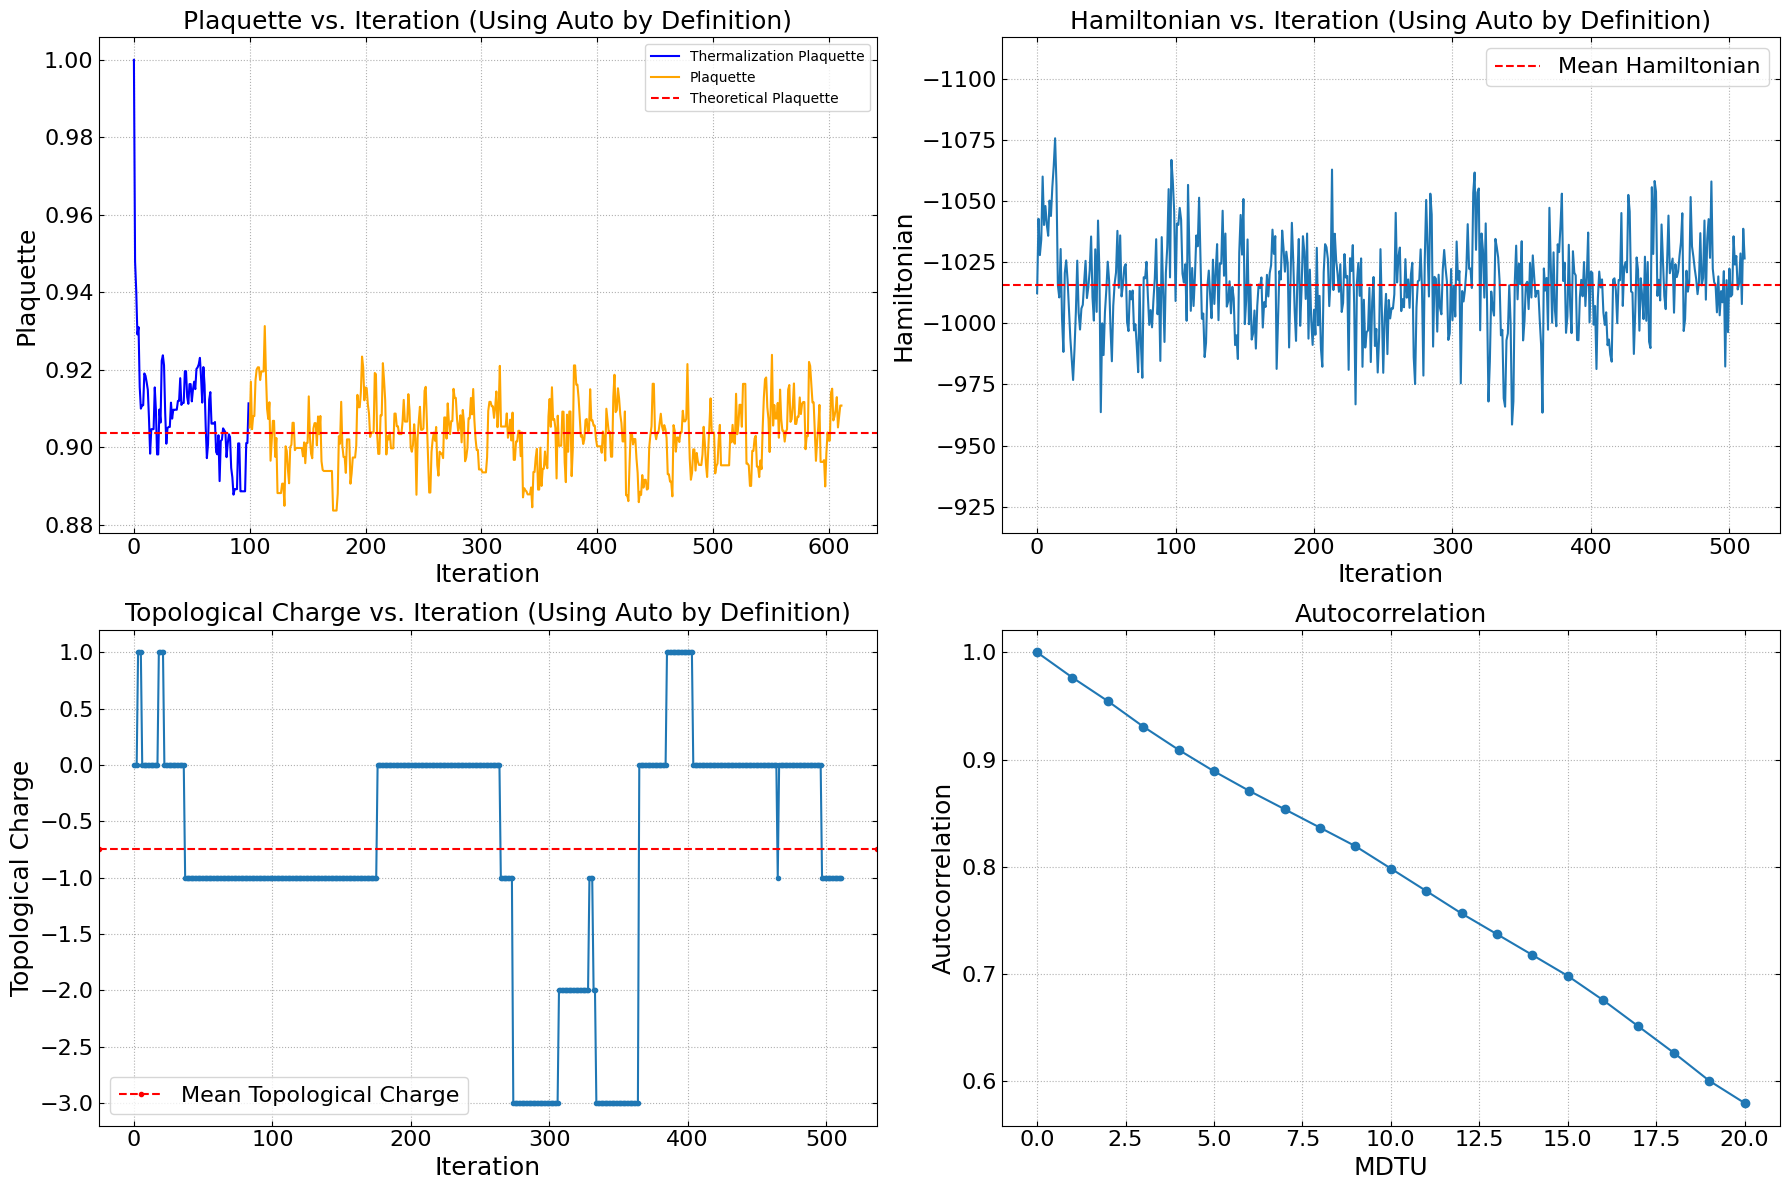

>>> Mean plaq:  0.9030729129444808
>>> Std plaq:  0.008274325897831772


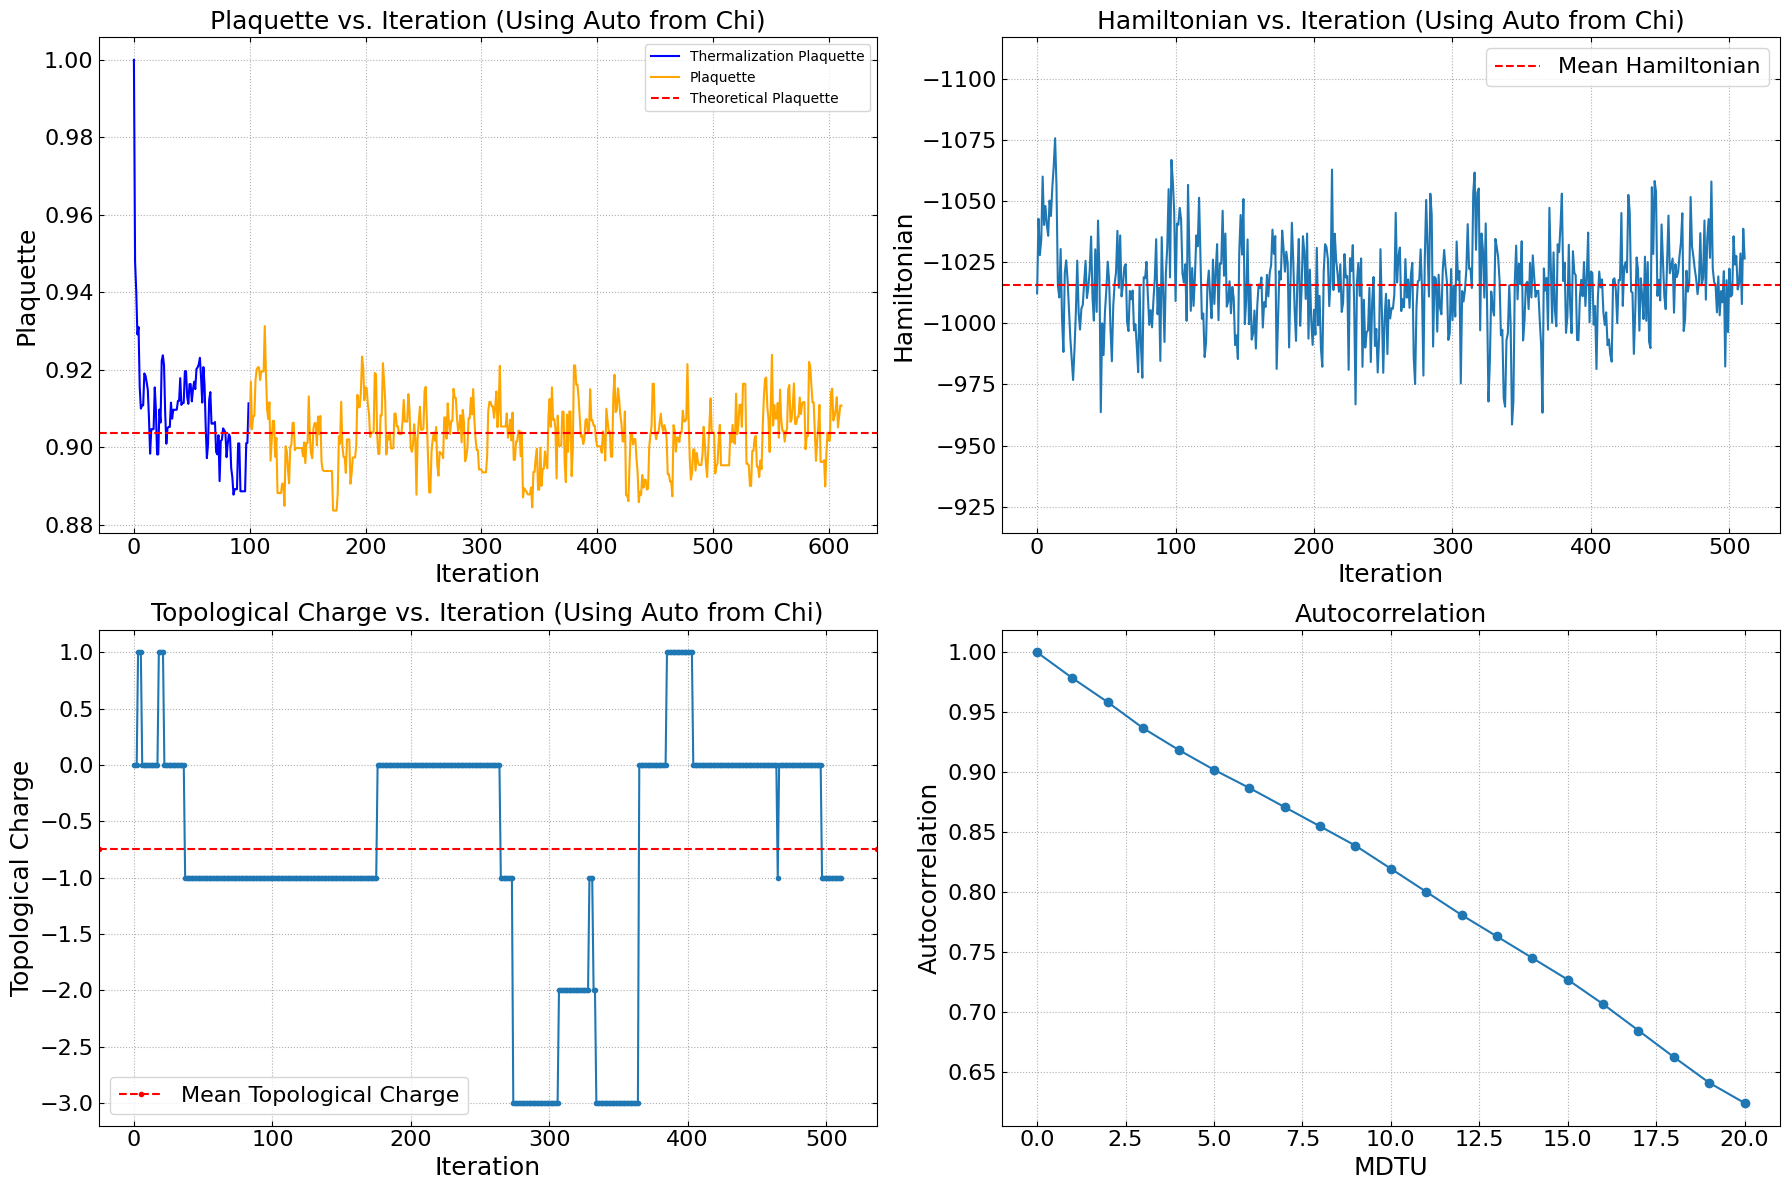

Thermalization acceptance rate: 0.7900
Acceptance rate: 0.7598


In [3]:
print(">>> No Field Transformation HMC Simulation: ")

# Initialize HMC
hmc = HMC_U1(lattice_size, beta, n_thermalization_steps, n_steps, step_size, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)

### Neural Network Field Transformation

>>> Neural Network Field Transformation HMC Simulation: 


Training Neural Network: 100%|██████████| 200/200 [00:03<00:00, 58.89it/s]


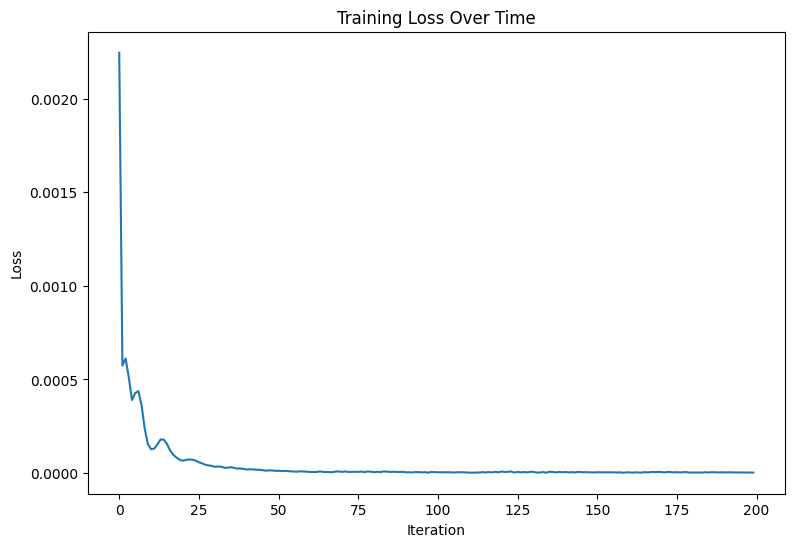


Neural Network Field Transformation Structure:
CNNModel(
  (conv_layers): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): Conv2d(32, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


Thermalizing:   0%|          | 0/100 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [5]:
print(">>> Neural Network Field Transformation HMC Simulation: ")

# Train the neural network force
nn_transformation = NNFieldTransformation(lattice_size, model_type='CNN', epsilon=0.1, epsilon_decay=1, jacobian_interval=20, device=device)
nn_transformation.train(beta, n_iterations=200)

# Print the trained neural network structure and parameters
print("\nNeural Network Field Transformation Structure:")
print(nn_transformation.model)


# Initialize HMC
hmc = HMC_U1_FT(lattice_size, beta, n_thermalization_steps, n_steps, step_size, field_transformation=nn_transformation, jacobian_interval=64, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
final_config, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized)

print(">>> Simulation completed")


# Compute autocorrelation of topological charges
max_lag = 20
hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)

In [8]:
import torch.linalg as linalg
import torch.autograd.functional as F

U_ini = torch.ones([2, lattice_size, lattice_size])
U_trans = nn_transformation(U_ini)
U_trans2 = nn_transformation(U_trans)
U_trans3 = nn_transformation(U_trans2)

def compute_jacobian_log_det(theta_new, field_transformation):
    """
    Compute the log determinant of the Jacobian matrix of the transformation.
    
    Parameters:
    -----------
    theta_new : torch.Tensor
        The new field configuration after transformation.
    """
    # Compute Jacobian using torch.autograd.functional.jacobian
    jacobian = F.jacobian(field_transformation, theta_new)

    # Reshape jacobian to 2D matrix
    jacobian_2d = jacobian.view(-1, jacobian.shape[-1])

    # Compute singular values
    s = linalg.svdvals(jacobian_2d)

    # Compute log determinant as sum of log of singular values
    log_det = torch.sum(torch.log(s))

    return log_det


print(U_trans[0,0,:])
print(U_trans[0,1,:])
print(compute_jacobian_log_det(U_ini, nn_transformation))


print(U_trans2[0,0,:])
print(U_trans2[0,1,:])
print(compute_jacobian_log_det(U_trans, nn_transformation))


print(U_trans3[0,0,:])
print(U_trans3[0,1,:])
print(compute_jacobian_log_det(U_trans2, nn_transformation))

tensor([0.9972, 0.9975, 0.9954, 0.9957, 0.9957, 0.9957, 0.9957, 0.9957, 0.9957,
        0.9957, 0.9957, 0.9957, 0.9957, 0.9948, 0.9930, 0.9913],
       device='cuda:0', grad_fn=<SliceBackward0>)
tensor([0.9954, 0.9953, 0.9935, 0.9947, 0.9947, 0.9947, 0.9947, 0.9947, 0.9947,
        0.9947, 0.9947, 0.9947, 0.9947, 0.9937, 0.9950, 0.9938],
       device='cuda:0', grad_fn=<SliceBackward0>)
tensor(27.7089, device='cuda:0')
tensor([0.9943, 0.9949, 0.9908, 0.9915, 0.9915, 0.9915, 0.9915, 0.9915, 0.9915,
        0.9915, 0.9915, 0.9915, 0.9915, 0.9896, 0.9861, 0.9825],
       device='cuda:0', grad_fn=<SliceBackward0>)
tensor([0.9908, 0.9907, 0.9870, 0.9894, 0.9894, 0.9894, 0.9894, 0.9894, 0.9894,
        0.9894, 0.9894, 0.9894, 0.9894, 0.9875, 0.9900, 0.9875],
       device='cuda:0', grad_fn=<SliceBackward0>)
tensor(27.7089, device='cuda:0')
tensor([0.9915, 0.9924, 0.9861, 0.9873, 0.9873, 0.9873, 0.9873, 0.9873, 0.9873,
        0.9873, 0.9873, 0.9872, 0.9872, 0.9844, 0.9791, 0.9738],
       de